<a href="https://colab.research.google.com/github/ajit04022000/Topic_Modeling/blob/main/Topic_modeling_steps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

%matplotlib inline

In [16]:
datafile = '/content/drive/MyDrive/8)TOPIC MODELING/abcnews-date-text.csv'
raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)

reindexed_data = raw_data['headline_text']
# reindexed_data.index = raw_data['publish_date']

raw_data.head()

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


In [ ]:
raw_data

In [10]:
len(raw_data)
print(raw_data.shape)

(1226258, 2)


### First we develop a list of the top words used across all one million headlines, giving us a glimpse into the core vocabulary of the source data. Stop words are omitted here to avoid any trivial conjunctions, prepositions, etc.

In [12]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

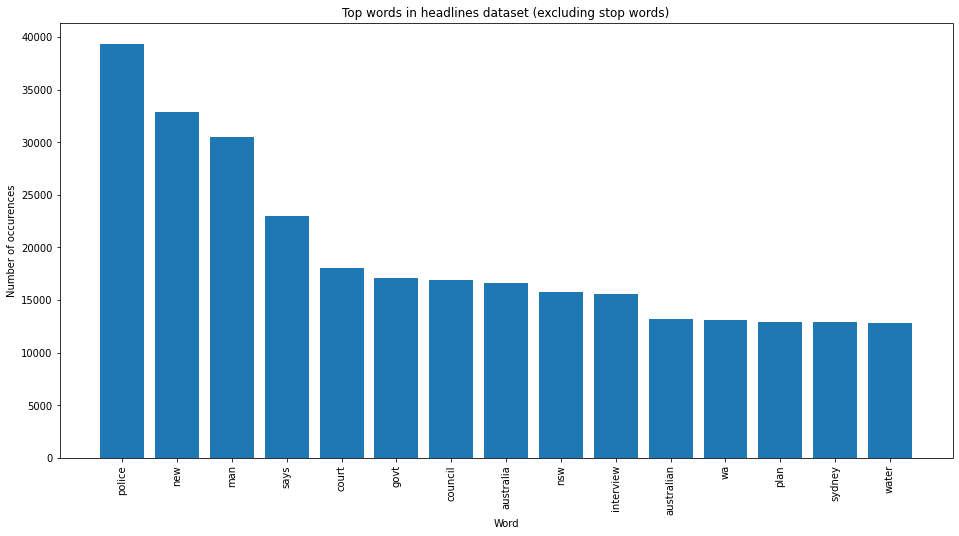

In [13]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset (excluding stop words)')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

In [14]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=4000)
small_text_sample = reindexed_data.sample(n=10000, random_state=0).values

print('Headline before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization: man jailed for theft of police files
Headline after vectorization: 
  (0, 2196)	1
  (0, 2662)	1
  (0, 1917)	1
  (0, 3596)	1


In [15]:
# Parameters tuning using Grid Search
from sklearn.model_selection import GridSearchCV
grid_params = {'n_components' : list(range(5,10))}

# LDA model
lda = LatentDirichletAllocation()
lda_model = GridSearchCV(lda,param_grid=grid_params)
lda_model.fit(small_document_term_matrix)

# Best LDA model
best_lda_model = lda_model.best_estimator_

print("Best LDA model's params" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on train data", best_lda_model.perplexity(small_document_term_matrix))

Best LDA model's params {'n_components': 5}
Best log likelihood Score for the LDA model -82776.9101535568
LDA model Perplexity on train data 3957.530632694275


In [21]:
dtm = count_vectorizer.fit_transform(raw_data['headline_text'])
dtm

<1226258x104399 sparse matrix of type '<class 'numpy.int64'>'
	with 6364039 stored elements in Compressed Sparse Row format>

In [33]:
from sklearn.decomposition import NMF
LDA = NMF(n_components=5,random_state=42)
LDA.fit(dtm)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


NMF(n_components=5, random_state=42)

In [34]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([count_vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['shooting', 'seek', 'arrest', 'fatal', 'say', 'hunt', 'officer', 'crash', 'car', 'death', 'search', 'missing', 'investigate', 'probe', 'police']


THE TOP 15 WORDS FOR TOPIC #1
['gets', 'set', 'cases', 'south', 'deal', 'centre', 'years', 'hospital', 'home', 'coronavirus', 'york', 'year', 'laws', 'zealand', 'new']


THE TOP 15 WORDS FOR TOPIC #2
['child', 'sydney', 'woman', 'missing', 'guilty', 'car', 'death', 'crash', 'jailed', 'dies', 'accused', 'murder', 'court', 'charged', 'man']


THE TOP 15 WORDS FOR TOPIC #3
['china', 'expert', 'chief', 'wont', 'group', 'opposition', 'government', 'report', 'union', 'pm', 'labor', 'trump', 'mp', 'minister', 'says']


THE TOP 15 WORDS FOR TOPIC #4
['rural', 'south', 'coast', 'sa', 'court', 'urged', 'health', 'wa', 'qld', 'water', 'plan', 'australia', 'nsw', 'council', 'govt']




In [35]:
topic_results = LDA.transform(dtm)

In [36]:
raw_data.head()

,publish_date,headline_text,Topic
0,2003-02-19,aba decides against community broadcasting lic...,4
1,2003-02-19,act fire witnesses must be aware of defamation,4
2,2003-02-19,a g calls for infrastructure protection summit,4
3,2003-02-19,air nz staff in aust strike for pay rise,4
4,2003-02-19,air nz strike to affect australian travellers,6


In [37]:
topic_results.argmax(axis=1)

array([4, 4, 4, ..., 1, 4, 4])

In [38]:
raw_data['Topic'] = topic_results.argmax(axis=1)

In [39]:
raw_data.head(10)

,publish_date,headline_text,Topic
0,2003-02-19,aba decides against community broadcasting lic...,4
1,2003-02-19,act fire witnesses must be aware of defamation,4
2,2003-02-19,a g calls for infrastructure protection summit,4
3,2003-02-19,air nz staff in aust strike for pay rise,4
4,2003-02-19,air nz strike to affect australian travellers,4
5,2003-02-19,ambitious olsson wins triple jump,4
6,2003-02-19,antic delighted with record breaking barca,4
7,2003-02-19,aussie qualifier stosur wastes four memphis match,4
8,2003-02-19,aust addresses un security council over iraq,4
9,2003-02-19,australia is locked into war timetable opp,4


In [40]:
raw_data['Topic'].nunique()

5

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

In [43]:
lda_panel = pyLDAvis.sklearn.prepare(best_lda_model, small_document_term_matrix,small_count_vectorizer,mds='tsne')
lda_panel

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distan

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      150.222153  -72.269554       1        1  20.729127
4       51.163364 -159.968018       2        1  20.550188
3      -73.144554   21.523815       3        1  19.801846
2      -66.410133 -110.606438       4        1  19.729677
1       54.417324   12.443444       5        1  19.189162, topic_info=           Term        Freq       Total Category  logprob  loglift
2196        man  228.000000  228.000000  Default  30.0000  30.0000
892       court  113.000000  113.000000  Default  29.0000  29.0000
1872  interview  105.000000  105.000000  Default  28.0000  28.0000
3515     sydney   97.000000   97.000000  Default  27.0000  27.0000
2365     murder   87.000000   87.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
3095         sa   28.127918   76.831956   Topic5  -5.6419   0.6460
2803        qld   29.257882   97.862803   Topic5  -5.6025   0.4434
2662     police   36.657560  304.372351   Topic5  -5.3771  -0.4658
1595       govt   27.999647  122.251415   Topic5  -5.6465   0.1769
2435        nsw   27.500876  125.221466   Topic5  -5.6645   0.1350

[311 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
53        1  0.972949       50
66        2  0.753755    abuse
66        4  0.231925    abuse
75        1  0.988387  accused
80        2  0.939349      act
...     ...       ...      ...
3962      4  0.780973     work
3971      2  0.724322    world
3971      4  0.217297    world
3971      5  0.057946    world
3995      4  0.927935  zealand

[465 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 3, 2])